# About Dataset

### Data Science Job Salaries Dataset contains 11 columns, each are:

* work_year: The year the salary was paid.
* experience_level: The experience level in the job during the year
* employment_type: The type of employment for the role
* job_title: The role worked in during the year.
* salary: The total gross salary amount paid.
* salary_currency: The currency of the salary paid as an ISO 4217 currency code.
* salary_in_usd: The salary in USD
* employee_residence: Employee's primary country of residence in during the work year as an ISO 3166 country code.
* remote_ratio: The overall amount of work done remotely
* company_location: The country of the employer's main office or contracting branch
* company_size: The median number of people that worked for the company during the year


In [442]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import pandas as pd
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"

input_file = "ds_salaries.csv"
data = pd.read_csv(input_file, header = 0)
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [443]:
data.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


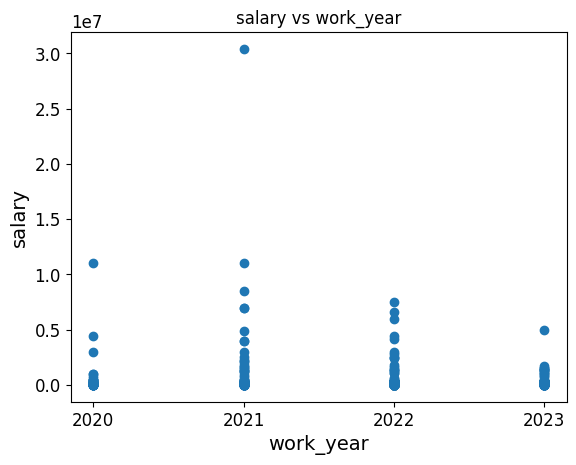

In [444]:
import matplotlib.pyplot as plt

# Create a scatter plot of YearsExperience vs Salary
plt.scatter(data['work_year'], data['salary'])

# Add labels and title to the plot
plt.xticks(range(int(min(data['work_year'])), int(max(data['work_year']))+1, 1))

plt.xlabel('work_year')
plt.ylabel('salary')
plt.title('salary vs work_year')

# Show the plot
plt.show()

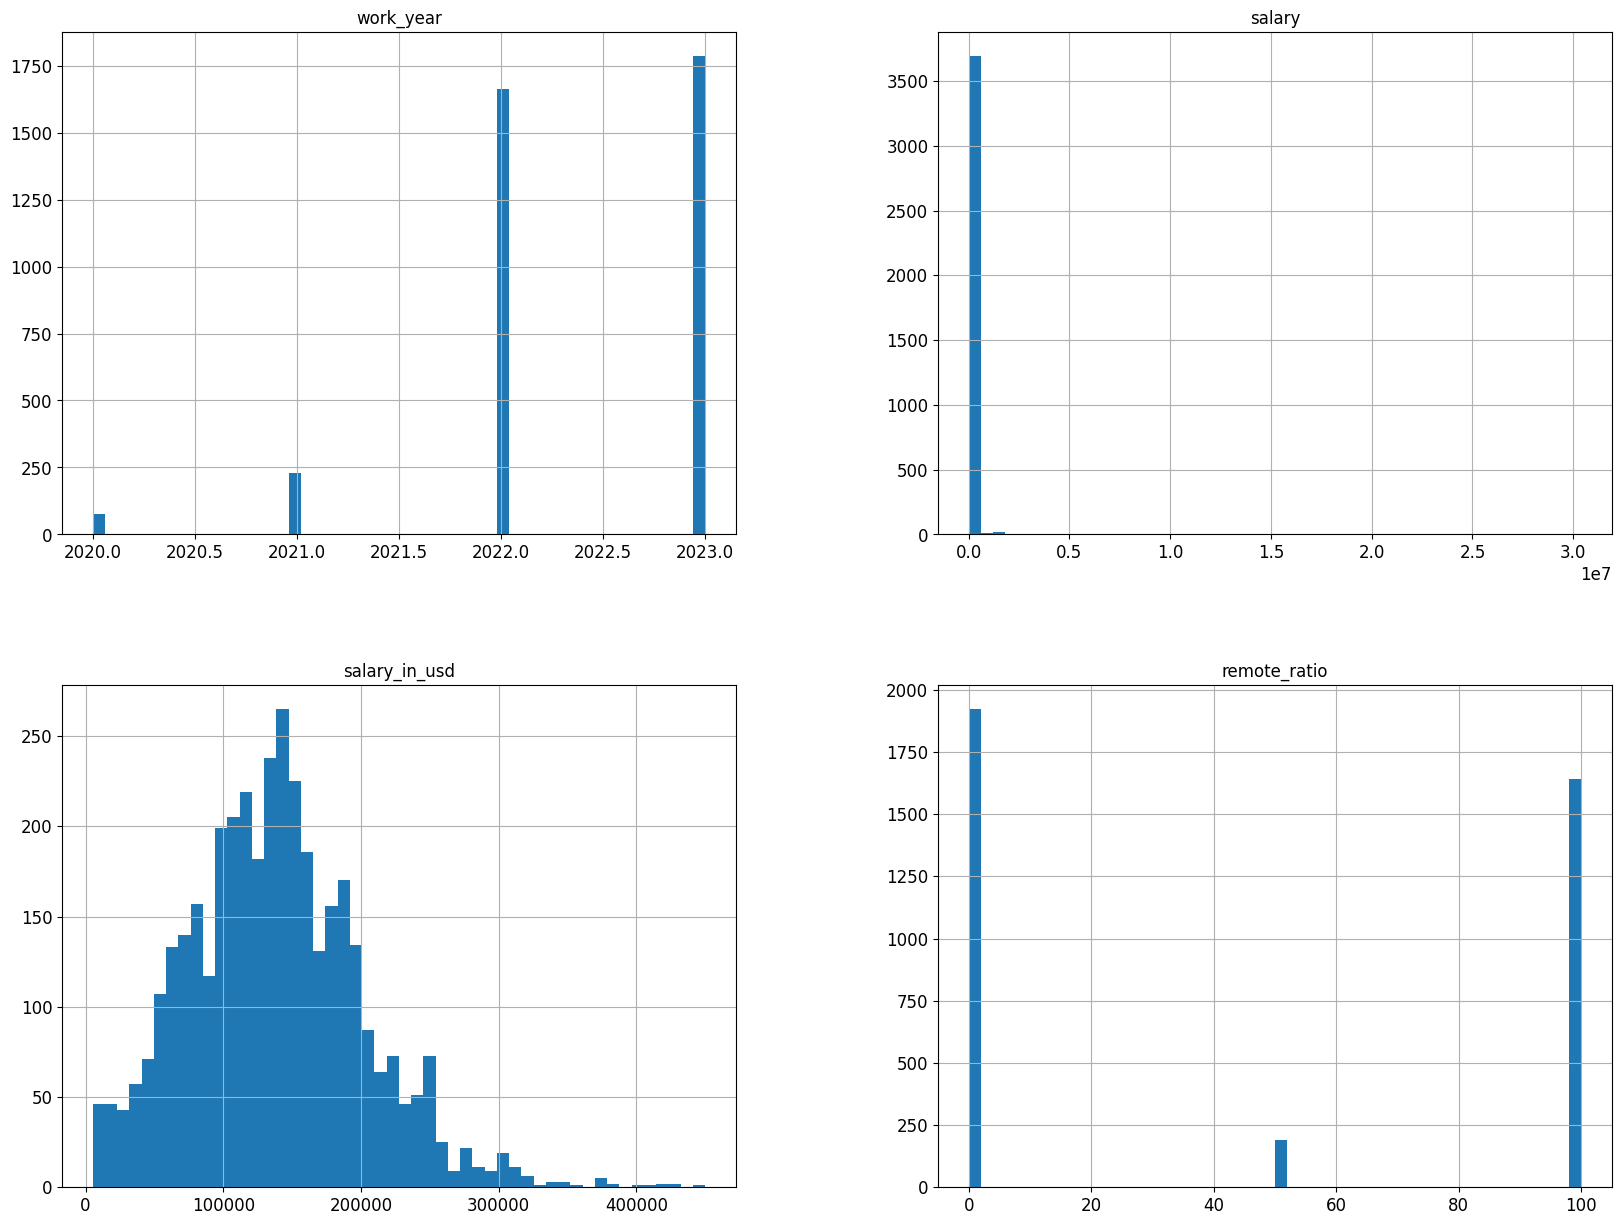

In [445]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))

plt.show()

# Analyzing the data

##### We want so see which job titles are more frequent

In [446]:
job_count=data['job_title'].value_counts()
job_count

Data Engineer                          1040
Data Scientist                          840
Data Analyst                            612
Machine Learning Engineer               289
Analytics Engineer                      103
                                       ... 
Principal Machine Learning Engineer       1
Azure Data Engineer                       1
Manager Data Management                   1
Marketing Data Engineer                   1
Finance Data Analyst                      1
Name: job_title, Length: 93, dtype: int64

##### We can see that there are a lot of unique job titles. We will later simplify the data to focus on the first 5 big categories

### Salaries based on the top 5 job titles

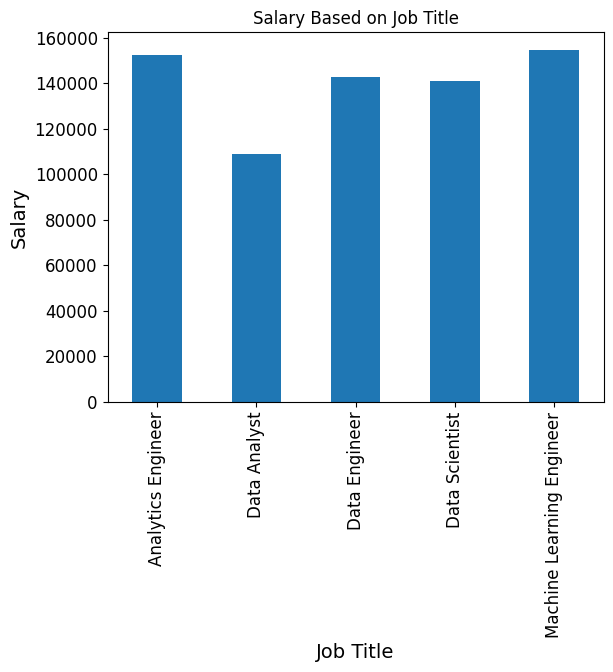

In [447]:
#get the first 5 jobs
top5_jobs = job_count.index[:5].tolist()
#filter data so we only look for the jobs required
filtered_data = data[data['job_title'].isin(top5_jobs)]
grouped_data = filtered_data.groupby('job_title')['salary_in_usd'].mean()
grouped_data.plot(kind='bar')
plt.xlabel('Job Title')
plt.ylabel('Salary')
plt.title('Salary Based on Job Title')
plt.show()

#### The salaries are similar between categories, except for the Data Analyst, which is significantly lower than the other four even if it is the second most frequent job.
#### We will next check how the salary increases based on employment level

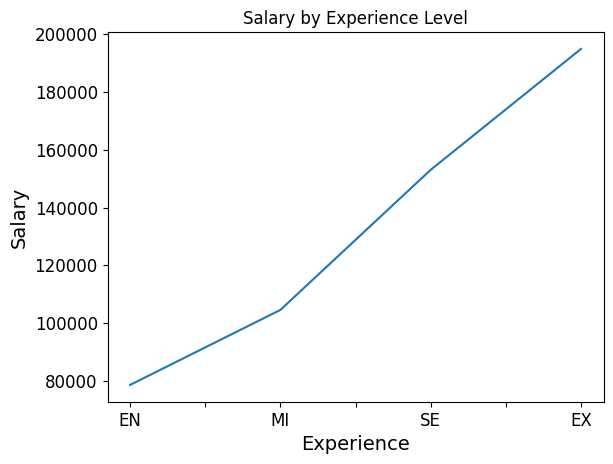

In [448]:
# compute avg salary for each category
mean_salary = data.groupby('experience_level')['salary_in_usd'].mean()

#change the order so the growth is better illustrated
experience_level_order = ['EN', 'MI', 'SE', 'EX']
mean_salary = mean_salary.reindex(experience_level_order)

#plot
mean_salary.plot(kind='line')
plt.title('Salary by Experience Level')
plt.xlabel('Experience')
plt.ylabel('Salary')
plt.show()

#### The graph shows that the salary does not increase that much from Entry Level to Mid Level. However, after reaching Mid Level there is almost a linear growth, reaching to more than double the amount of the initial value.
#### Now lets add job titles into the mix

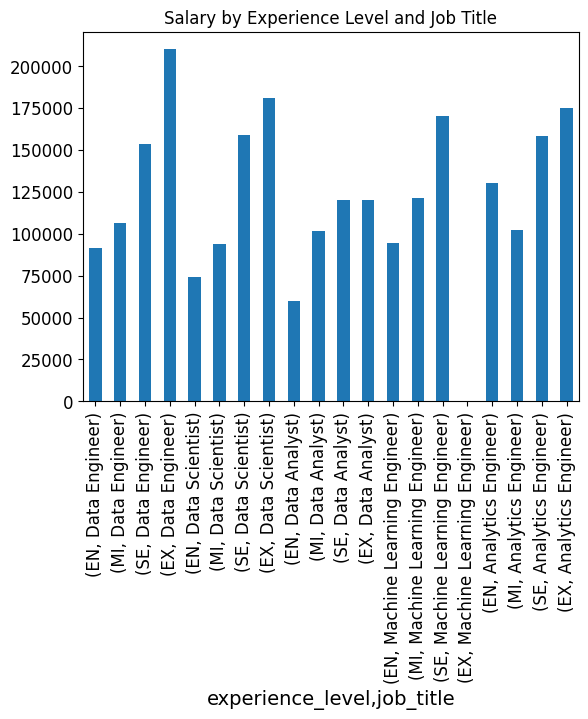

In [449]:
# we used the previously defined filtered data with jobs in the top 5
from itertools import product
mean_salary = filtered_data.groupby(['experience_level', 'job_title'])['salary_in_usd'].mean()

# this is a cartesian product to index first by title then by experience level
idx = list(product(top5_jobs,experience_level_order))
mean_salary = mean_salary.reindex([(e[1], e[0]) for e in idx])


#plot
mean_salary.plot(kind='bar')
plt.title('Salary by Experience Level and Job Title')
plt.show()

# Clean up the set


#### Check if there are any missing values in our columns

In [450]:
#check for missing values

columns_with_miss = data.isna().sum()
#filtering only the columns with at least 1 missing value
columns_with_miss = columns_with_miss[columns_with_miss!=0]
#The number of columns with missing values
print('Columns with missing values:', len(columns_with_miss))
#sorting the columns by the number of missing values descending
columns_with_miss.sort_values(ascending=False)

Columns with missing values: 0


Series([], dtype: int64)

#### Drop the unuseful columns: salary, salary_currency (both covered by salary_in_usd).

In [ ]:
data.drop(columns=['salary', 'salary_currency'], inplace=True)
data

### Transform String data to Integer values
#### First, print all column's possible values to see what we are working with

In [ ]:
for column in data.columns:
    if data[column].dtype != 'int64':
        print(data[column].value_counts())
print(data['company_location'].value_counts())

#### Codify simple, ordinal data
experience_level (entry, mid, senior, executive)

In [453]:
data['experience_level'].replace({
    'EN': 1,
    'MI': 2,
    'SE': 3,
    'EX': 4,
}, inplace=True)

company_size (S, M, L)

In [454]:
data['company_size'].replace({
    'S': 1,
    'M': 2,
    'L': 3
}, inplace=True)

remote_ratio (0, 50, 100) ->  (0, 1, 2)

In [455]:
data['remote_ratio'].replace({
    0: 0,
    50: 1,
    100: 2
}, inplace=True)

#### Codify non-ordinal data
by converting a column to multiple binary value columns

In [456]:
def one_hot_encode_column(data, column):
    dummies = pd.get_dummies(data[column], prefix=column)
    data = pd.concat([data, dummies], axis=1)
    data.drop(columns=[column], inplace=True)
    return data
min_occurences = 5 
def bin_values(data, column):
    # Number of occurrences
    counts = data[column].value_counts()
    # Create a list with all values that have less than x occurrences
    other_values = list(counts[counts < min_occurences].index)
    # Replace the values in the "other_values" list with "Other"
    data[column].replace(other_values, "Other", inplace=True)
    return data

employment_type
FT    2973
PT      15
CT       9
FL       7

In [ ]:
data = one_hot_encode_column(data, 'employment_type')
data

job_title simplification (reduce it to 4 main job categories)

In [458]:
def map_job_title_to_category(job_title):
    if "analyst" in job_title.lower():
        return "Data Analyst"
    elif "machine" in job_title.lower():
        return "Machine Learning Engineer"
    elif "scientist" in job_title.lower():
        return "Data Scientist"
    elif "engineer" in job_title.lower():
        return "Data Engineer"
    else:
        return "Other"

# Create a new column called "job_category" and remove old column
data["job_category"] = data["job_title"].apply(map_job_title_to_category)
data["job_category"].value_counts()
data = data.drop('job_title', axis=1)



In [459]:
data = bin_values(data, 'job_category')
data = one_hot_encode_column(data, 'job_category')

In [ ]:
data

employee_residence (bin all countries with less than x value)

In [461]:
data = bin_values(data, 'employee_residence')
data = one_hot_encode_column(data, 'employee_residence')

In [ ]:
data

company_location (bin all countries with less than x value)

In [463]:
data = bin_values(data, 'company_location')
data = one_hot_encode_column(data, 'company_location')

In [ ]:
data

In [ ]:
data.value_counts()

In [ ]:
data.describe()

# Test set

In [467]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [468]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [469]:
from sklearn.model_selection import StratifiedShuffleSplit

# stratify by experience level since that is one of the most important attributes
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["experience_level"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [470]:
#check distribution of train and test
strat_test_set["experience_level"].value_counts() / len(strat_test_set)

3    0.669774
2    0.214381
1    0.085220
4    0.030626
Name: experience_level, dtype: float64

In [471]:
strat_train_set["experience_level"].value_counts() / len(strat_train_set)

3    0.670107
2    0.214381
1    0.085220
4    0.030293
Name: experience_level, dtype: float64

#### Check distribution of Experience_level in different sets: Overall, Stratified, Randomized

In [472]:
def income_cat_proportions(data):
    return data["experience_level"].value_counts() / len(data)

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(data),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.085220,0.085220,0.089214,4.687500,0.000000
2,0.214381,0.214381,0.209055,-2.484472,0.000000
3,0.670040,0.669774,0.671105,0.158983,-0.039746
4,0.030360,0.030626,0.030626,0.877193,0.877193


In [473]:
#cautam corelatia dintre salariu si restul atributelor
data = strat_train_set.copy()
corr_matrix = data.corr()
corr_matrix["salary_in_usd"].sort_values(ascending=False)

salary_in_usd                1.000000
employee_residence_US        0.489980
company_location_US          0.471980
experience_level             0.446558
work_year                    0.235873
                               ...   
company_location_ES         -0.191116
company_location_IN         -0.205135
company_location_Other      -0.209175
employee_residence_IN       -0.223766
job_category_Data Analyst   -0.229206
Name: salary_in_usd, Length: 62, dtype: float64

### Remove outlier salary rows
IQR represents the middle 50% of ordered values. It is calculated as the difference between the first Quartile (the lowest 10% in our case) amd the third Quartile( the biggest 10%).

In our testing this didn't bring a significant improvement in our model (under 0.5% improvement). 

Therefore, it is safe to draw the conclusion that the salaries are well spread and there are few outliers that cause inconsistencies.

In [474]:
# Calculate the first and third quartiles
Q1, Q3 = np.percentile(data['salary_in_usd'], [10, 90])

# Calculate the interquartile range
IQR = Q3 - Q1

# Calculate the lower and upper bounds for outliers
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# Print the lower and upper bounds
print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)

# Find the outliers in the salaries column
outliers = data[(data['salary_in_usd'] < lower_bound) | (data['salary_in_usd'] > upper_bound)]

# Print the outliers
print(outliers)

# Remove the outliers
data = data[(data['salary_in_usd'] > lower_bound) & (data['salary_in_usd'] < upper_bound)]

Lower bound: -184235.0
Upper bound: 462541.0
Empty DataFrame
Columns: [work_year, experience_level, salary_in_usd, remote_ratio, company_size, employment_type_CT, employment_type_FL, employment_type_FT, employment_type_PT, job_category_Data Analyst, job_category_Data Engineer, job_category_Data Scientist, job_category_Machine Learning Engineer, job_category_Other, employee_residence_AR, employee_residence_AT, employee_residence_AU, employee_residence_BE, employee_residence_BR, employee_residence_CA, employee_residence_DE, employee_residence_ES, employee_residence_FR, employee_residence_GB, employee_residence_GR, employee_residence_IE, employee_residence_IN, employee_residence_IT, employee_residence_JP, employee_residence_MX, employee_residence_NG, employee_residence_NL, employee_residence_Other, employee_residence_PK, employee_residence_PL, employee_residence_PR, employee_residence_PT, employee_residence_SG, employee_residence_TR, employee_residence_US, company_location_AT, company_loc

# Train data

In [475]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Separate the target variable (salary_in_usd) from the features
X = data.drop(['salary_in_usd'], axis=1)
y = data['salary_in_usd']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model to the training data
reg = LinearRegression().fit(X_train, y_train)

# Predict salaries for the test set
y_pred = reg.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
mse = np.sqrt(mse)
print("Mean squared error: {:.2f}".format(mse))
print("Root mean squared error: {:.2f}".format(np.sqrt(mse)))

# Calculate the mean salary in the test set
mean_salary = y_test.mean()
print("Mean salary: {:.2f}".format(mean_salary))
print('Mean squared error (%):', mse/mean_salary*100)

Mean squared error: 49277.74
Root mean squared error: 221.99
Mean salary: 137307.07
Mean squared error (%): 35.88871500411348


In [441]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#remove location columns
# data = data.drop(['work_year'], axis=1)
#Dropping the work_year reduces accuracy of our result by about 0.5% so while 
#it is not a very important feature it is still somewhat useful to keep it

# Separate the target variable (salary_in_usd) from the features
X = data.drop(['salary_in_usd'], axis=1)
y = data['salary_in_usd']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model to the training data
dt_model = RandomForestRegressor().fit(X_train, y_train)

# Predict salaries for the test set
y_pred = dt_model.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
mse = np.sqrt(mse)
print("Mean squared error: {:.2f}".format(mse))

# Calculate the mean salary in the test set
mean_salary = y_test.mean()
print("Mean salary: {:.2f}".format(mean_salary))
print('Mean squared error (%):', mse/mean_salary*100)

Mean squared error: 49428.56
Mean salary: 137307.07
Mean squared error (%): 35.99855105840675


#### Compute r_squared metric
This measures the proportion of the variance in the dependent variable (salary) that is explained by the features in the model. 
We can see that the r_squared metric is not very impressive here , which is possibly due to our low 

In [364]:
from sklearn.metrics import r2_score

r_squared = r2_score(y_test, y_pred)

print("R^2: {:.2f}".format(r_squared))

R^2: 0.34


#### Compute MAE metric
This measures the proportion of the variance in the dependent variable (salary) that is explained by the features in the model

In [365]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

avg_y_test = np.mean(y_test)

print('Mean Absolute Error (%):', mae/avg_y_test*100)

Mean Absolute Error: 37988.07273578943
Mean Absolute Error (%): 27.666508248505224


## Applying Random Forest Regression

##### Random Forest consists of multiple decision trees used together, hence the naming. 
##### Because we are using it for a regression problem (predicting salaries), the forest will compute the average of every decision tree.

In [185]:
#separate the data
X=data.drop(['salary_in_usd'],axis = 1)
y=data['salary_in_usd']

# split into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [186]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# random forest regression
# n_estimators means the amount of decision trees to be generated
# max_depth specifies the depth of the trees
random_forest = RandomForestRegressor(n_estimators=100, max_depth=10)

In [187]:
# model training
random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [188]:
# model verification
y_pred = random_forest.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error:", mae)
avg_y_test = np.mean(y_test)
print('Mean Absolute Error (%):', mae/avg_y_test*100)

Mean absolute error: 37220.306186677255
Mean Absolute Error (%): 27.107348016511505


##### We can observe that the random forest prediction are roughly the same as those predicted using linear regression.